In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
sns.set(style="darkgrid")

import statsmodels.api as sm

In [2]:
from paths_usa import *

# plot gradual commissioning

In [239]:
cap = turb_mer.capacity.values
comyear = pd.to_datetime(turb_mer.commissioning.values).year.values

In [264]:
comdate = pd.to_datetime([str(y)+'-12-31 23:00:00' for y in comyear])

In [265]:
com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()

In [266]:
cap_cum = com.capacity.cumsum()

In [267]:
dry = pd.to_datetime([str(y)+'-12-31 23:00:00' for y in range(2001,2019)])

In [268]:
cap_cumy = pd.Series(dry.map(cap_cum),index=dry).fillna(method='ffill')

In [269]:
dr = pd.date_range('1/1/2000','31/12/2018 23:00:00',freq = 'h')
cap_ts = pd.Series(dr.map(cap_cumy),index = dr)

In [270]:
cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2000-01-01')].max()

In [271]:
c = cap_ts.interpolate(method='linear')

In [274]:
def get_cap_df(cap,comdate):
    com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()
    cap_cum = com.capacity.cumsum()
    dr = pd.date_range('1/1/2000','31/12/2018 23:00:00',freq = 'h')
    cap_ts = pd.Series(dr.map(cap_cum),index = dr)
    cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2000-01-01')].max()
    return(cap_ts.fillna(method='ffill'))

def get_cap_df_grad(cap,comyear):
    comdate = pd.to_datetime([str(y)+'-12-31 23:00:00' for y in comyear])
    com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()
    cap_cum = com.capacity.cumsum()
    dry = pd.to_datetime([str(y)+'-12-31 23:00:00' for y in range(2001,2019)])
    cap_cumy = pd.Series(dry.map(cap_cum),index=dry).fillna(method='ffill')
    dr = pd.date_range('1/1/2000','31/12/2018 23:00:00',freq = 'h')
    cap_ts = pd.Series(dr.map(cap_cumy),index = dr)
    cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2000-01-01')].max()
    return(cap_ts.interpolate(method='linear'))
    
    
### Prepare wind park data - Installed capacities
# get aggregated turbine data
turb_mer = pd.read_csv(usa_path + "/turbine_data_mer.csv",parse_dates = ['commissioning']).drop('Unnamed: 0',axis=1)
# get capacities time series for all regions
cap_usa = get_cap_df(turb_mer.capacity.values,
                     turb_mer.commissioning.values).tz_localize('UTC').tz_convert('US/Central')
cap_usa_grad = get_cap_df_grad(turb_mer.capacity.values,
                              pd.to_datetime(turb_mer.commissioning.values).year.values).tz_localize('UTC').tz_convert('US/Central')
# aggregate daily or monthly where needed
cap_usam = cap_usa.resample('M').sum()
cap_usam_grad = cap_usa_grad.resample('M').sum()

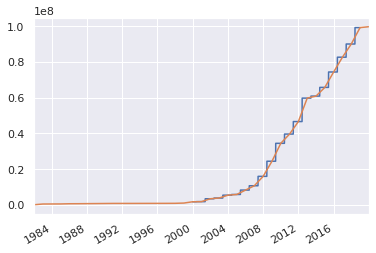

In [272]:
cap_usa.plot()
cap_cum.plot()

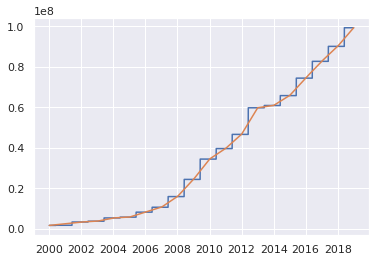

In [275]:
plt.plot(cap_usa)
plt.plot(cap_usa_grad)

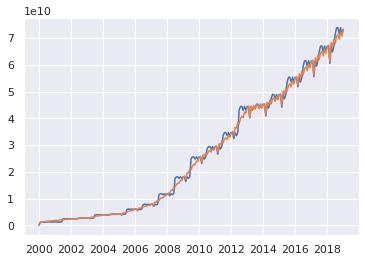

In [277]:
plt.plot(cap_usam)
plt.plot(cap_usam_grad)

In [278]:
### Analysis capacity factors

## USA monthly
# Load production data
# Source: https://www.eia.gov/electricity/data/browser/#/topic/0?agg=1,0,2&fuel=008&geo=vvvvvvvvvvvvo&sec=o3g&linechart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&columnchart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&map=ELEC.GEN.WND-US-99.M&freq=M&start=200101&end=201903&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&pin=&rse=0&maptype=0
prod_USAm = pd.read_csv(usa_path+"/generation_data/USA_monthly/Net_generation_wind_all_sectors_monthly.csv",header=4)
# arrange data
# rename columns
prod_USAm.columns = ['time','wp_obs','Iowa','Texas']
# sort indices
prod_USAm = prod_USAm[~np.isnan(prod_USAm.wp_obs)].sort_index(axis=0 ,ascending=False)
# create datetime index
prod_USAm = prod_USAm.set_index(pd.to_datetime(prod_USAm.time.values)).drop(['time'],axis=1)
# cut after 2018
prod_USAm = prod_USAm[prod_USAm.index < np.datetime64("2019-01-01")].tz_localize('US/Central')

In [279]:
results_path_grad = '/data/users/kgruber/results/USA/'

In [280]:
wpM_grad = xr.open_dataset(results_path_grad+"/windpower_stat_MERRA2.nc").sum('location').to_dataframe()

In [281]:
wpE_grad = xr.open_dataset(results_path_grad+"/windpower_stat_ERA5.nc").sum('location').to_dataframe()

In [282]:
wp_USA = pd.concat([wpM_grad,wpE_grad],axis=1).tz_localize('UTC').tz_convert('US/Central')
wp_USA.columns = ['ERA5','MERRA2']
# aggregate monthly
wp_USAm = wp_USA.resample('M').sum()
# combine data
comp_USAm = pd.concat([wp_USAm,prod_USAm.resample('M').sum().wp_obs*10**6],axis=1)
# calculate capacity factors
cf_USAm = comp_USAm.div(cap_usam_grad,axis=0).dropna()

In [ ]:
comp_USAm.plot()
plt.title('gradual capacity increase')

In [ ]:
ds = cf_USAm
ds.plot()
plt.title('MERRA2 '+str(round(np.corrcoef(ds.MERRA2,ds.wp_obs)[0,1],3)) +
          ' | ERA5 ' + str(round(np.corrcoef(ds.ERA5,ds.wp_obs)[0,1],3)))

# Plot midyear commissioning

In [48]:
# Prepare simulated data
results_path_e82 = '/data/users/kgruber/results/USA/results_E82'
results_path_ryb = '/data/users/kgruber/results/USA/results_GWA2'
# load data
wpE = xr.open_dataset(results_path_e82+"/windpower_USA_ERA5.nc").to_dataframe()
wpE_GWA = xr.open_dataset(results_path_e82+"/windpower_USA_ERA5_GWA.nc").to_dataframe()
wpM = xr.open_dataset(results_path_e82+"/windpower_USA_MERRA2.nc").to_dataframe()
wpM_GWA = xr.open_dataset(results_path_e82+"/windpower_USA_MERRA2_GWA.nc").to_dataframe()

wpEryb = xr.open_dataset(results_path_ryb+"/windpower_USA_ERA5.nc").to_dataframe()
wpE_GWAryb = xr.open_dataset(results_path_ryb+"/windpower_USA_ERA5_GWA.nc").to_dataframe()
wpMryb = xr.open_dataset(results_path_ryb+"/windpower_USA_MERRA2.nc").to_dataframe()
wpM_GWAryb = xr.open_dataset(results_path_ryb+"/windpower_USA_MERRA2_GWA.nc").to_dataframe()

# merge data MERRA
wp_USAM = pd.concat([wpM,wpMryb],axis=1).tz_localize('UTC').tz_convert('US/Central')
wp_USAM.columns = ['E82','Ryberg']
# aggregate monthly
wp_USAMm = wp_USAM.resample('M').sum()
# combine data
comp_USAMm = pd.concat([wp_USAMm,prod_USAm.resample('M').sum().wp_obs*10**6],axis=1)
# calculate capacity factors
cf_USAMm = comp_USAMm.div(cap_usam,axis=0).dropna()

# merge data MERRA GWA
wp_USAMG = pd.concat([wpM_GWA,wpM_GWAryb],axis=1).tz_localize('UTC').tz_convert('US/Central')
wp_USAMG.columns = ['E82','Ryberg']
# aggregate monthly
wp_USAMGm = wp_USAMG.resample('M').sum()
# combine data
comp_USAMGm = pd.concat([wp_USAMGm,prod_USAm.resample('M').sum().wp_obs*10**6],axis=1)
# calculate capacity factors
cf_USAMGm = comp_USAMGm.div(cap_usam,axis=0).dropna()

# merge data ERA
wp_USAE = pd.concat([wpE,wpEryb],axis=1).tz_localize('UTC').tz_convert('US/Central')
wp_USAE.columns = ['E82','Ryberg']
# aggregate monthly
wp_USAEm = wp_USAE.resample('M').sum()
# combine data
comp_USAEm = pd.concat([wp_USAEm,prod_USAm.resample('M').sum().wp_obs*10**6],axis=1)
# calculate capacity factors
cf_USAEm = comp_USAEm.div(cap_usam,axis=0).dropna()

# merge data ERA GWA
wp_USAEG = pd.concat([wpE_GWA,wpE_GWAryb],axis=1).tz_localize('UTC').tz_convert('US/Central')
wp_USAEG.columns = ['E82','Ryberg']
# aggregate monthly
wp_USAEGm = wp_USAEG.resample('M').sum()
# combine data
comp_USAEGm = pd.concat([wp_USAEGm,prod_USAm.resample('M').sum().wp_obs*10**6],axis=1)
# calculate capacity factors
cf_USAEGm = comp_USAEGm.div(cap_usam,axis=0).dropna()

MERRA2

In [ ]:
comp_USAMm.plot()
plt.title('MERRA2')

In [ ]:
ds = cf_USAMm
ds.plot()
plt.title('MERRA2 Ryb'+str(round(np.corrcoef(ds.Ryberg,ds.wp_obs)[0,1],3)) +
          ' | E82 ' + str(round(np.corrcoef(ds.E82,ds.wp_obs)[0,1],3)))

MERRA2 GWA

In [ ]:
ds = comp_USAMGm.dropna()
ds.plot()
plt.title('MERRA2 GWA Ryb '+str(round(np.corrcoef(ds.Ryberg,ds.wp_obs)[0,1],3)) +
          ' | E82 ' + str(round(np.corrcoef(ds.E82,ds.wp_obs)[0,1],3)))

In [52]:
round(np.corrcoef(cf_USAMGm.Ryberg,cf_USAMGm.wp_obs)[0,1],3)

0.558

In [ ]:
ds = cf_USAMGm
ds.plot()
plt.title('MERRA2 GWA Ryb '+str(round(np.corrcoef(ds.Ryberg,ds.wp_obs)[0,1],3)) +
          ' | E82 ' + str(round(np.corrcoef(ds.E82,ds.wp_obs)[0,1],3)))

ERA5

In [ ]:
ds = comp_USAEm.dropna()
ds.plot()
plt.title('ERA5 Ryb '+str(round(np.corrcoef(ds.Ryberg,ds.wp_obs)[0,1],3)) +
          ' | E82 ' + str(round(np.corrcoef(ds.E82,ds.wp_obs)[0,1],3)))

In [55]:
np.corrcoef(comp_USAEm.dropna().Ryberg,comp_USAEm.dropna().wp_obs)[0,1]

0.9675373934203124

In [ ]:
ds = cf_USAEm.dropna()
ds.plot()
plt.title('ERA5 Ryb '+str(round(np.corrcoef(ds.Ryberg,ds.wp_obs)[0,1],3)) +
          ' | E82 ' + str(round(np.corrcoef(ds.E82,ds.wp_obs)[0,1],3)))

In [57]:
np.corrcoef(cf_USAEm.Ryberg,cf_USAEm.wp_obs)[0,1]

0.43932344735851714

ERA5 GWA

In [ ]:
ds = comp_USAEGm.dropna()
ds.plot()
plt.title('ERA5 GWA Ryb '+str(round(np.corrcoef(ds.Ryberg,ds.wp_obs)[0,1],3)) +
          ' | E82 ' + str(round(np.corrcoef(ds.E82,ds.wp_obs)[0,1],3)))

In [59]:
np.corrcoef(comp_USAEGm.dropna().E82,comp_USAEGm.dropna().wp_obs)[0,1]

0.9654277968382581

In [ ]:
ds = cf_USAEGm
ds.plot()
plt.title('ERA5 GWA Ryb '+str(round(np.corrcoef(ds.Ryberg,ds.wp_obs)[0,1],3)) +
          ' | E82 ' + str(round(np.corrcoef(ds.E82,ds.wp_obs)[0,1],3)))

In [79]:
cf_USAEGm2008 = cf_USAEGm[cf_USAEGm.index>pd.to_datetime('2008-01-01').tz_localize('US/Central')]
np.corrcoef(cf_USAEGm2008.Ryberg,cf_USAEGm2008.wp_obs)[0,1]

0.6472215848127697

In [81]:
cf_USAEGm2008 = cf_USAEGm[cf_USAEGm.index>pd.to_datetime('2008-01-01').tz_localize('US/Central')]
np.corrcoef(cf_USAEGm2008.E82,cf_USAEGm2008.wp_obs)[0,1]

0.635421747410096

In [82]:
cf_USAEGm2000 = cf_USAEGm[cf_USAEGm.index<pd.to_datetime('2008-01-01').tz_localize('US/Central')]
np.corrcoef(cf_USAEGm2000.Ryberg,cf_USAEGm2000.wp_obs)[0,1]

0.4591022729244155

In [ ]:
plt.scatter(cf_USAEGm2008.Ryberg,cf_USAEGm2008.wp_obs)

In [ ]:
plt.scatter(comp_USAEGm.Ryberg[1:],comp_USAEGm.wp_obs[1:])

In [ ]:
plt.plot(cf_USAEGm2008)

In [70]:
np.corrcoef(cf_USAEGm.Ryberg,cf_USAEGm.wp_obs)[0,1]

0.5106166524798769

### plot specific power over time

In [32]:
t_mer = pd.read_csv(usa_path + '/turbine_data_mer.csv',index_col = 0,parse_dates=['commissioning'])
t_mer_gwa = pd.read_csv(usa_path + '/turbine_data_mer_gwa.csv',index_col = 0,parse_dates=['commissioning'])
t_era = pd.read_csv(usa_path + '/turbine_data_era.csv',index_col = 0,parse_dates=['commissioning'])
t_era_gwa = pd.read_csv(usa_path + '/turbine_data_era_gwa.csv',index_col = 0,parse_dates=['commissioning'])

In [51]:
t_mer.sp[t_mer.sp>2000] = t_mer.sp.mean()

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
t_mer.sp.mean()

310.5105167094481

In [54]:
t_mer.sp.median()

314.2069728760344

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe866a8ad68>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe866aaa7b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe866a8abe0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe866aaaeb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe866aaafd0>],
 'means': []}

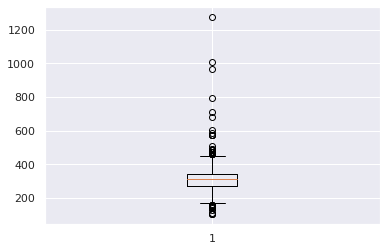

In [55]:
plt.boxplot(t_mer.sp)

Text(0, 0.5, 'specific power [W/m²]')

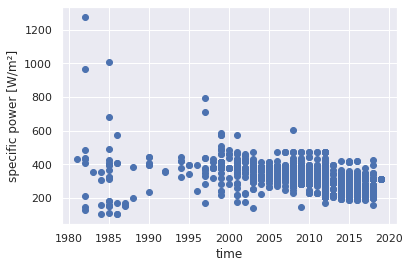

In [57]:
plt.scatter(t_mer.commissioning.dt.year,t_mer.sp)
plt.xlabel('time')
plt.ylabel('specific power [W/m²]')

Text(0, 0.5, 'hubheight [m]')

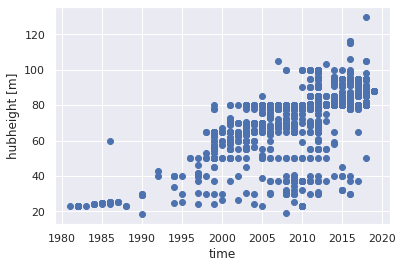

In [58]:
plt.scatter(t_mer.commissioning.dt.year,t_mer.height)
plt.xlabel('time')
plt.ylabel('hubheight [m]')

In [12]:
import glob
ofile = results_path_e82 + "/windpower_states_MERRA2.nc"
if ofile not in glob.glob(results_path_e82 + '/*'):
    turbine_data_mer = pd.read_csv(usa_path+"/turbine_data_mer.csv")
    wp_loc = xr.open_dataset(results_path_e82+"/windpower_stat_MERRA2.nc")
    wp = wp_loc.groupby(xr.DataArray(turbine_data_mer.state,dims='location')).sum('location')
    wp.to_netcdf(ofile)
    del(wp,wp_loc,turbine_data_mer)

In [14]:
ofile = results_path_e82+"/windpower_USA_MERRA2.nc"
if ofile not in glob.glob(results_path_e82 + "/*"):
    wp_state = xr.open_dataset(results_path_e82+"/windpower_states_MERRA2.nc")
    wpUSA = wp_state.sum('state')
    wpUSA.to_netcdf(ofile)

# Compare gradual and midyear commissioning

### Timeseries

Text(0.5, 1.0, 'MERRA2 gradual 0.968 | midyear 0.976')

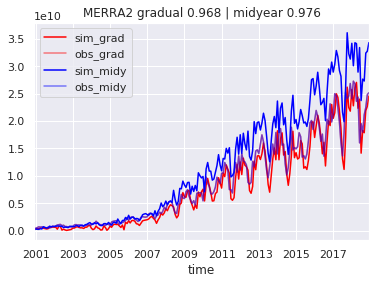

In [288]:
ax = plt.gca()
ds = pd.concat([comp_USAm.MERRA2,comp_USAm.wp_obs,comp_USAMm.Ryberg,comp_USAMm.wp_obs],axis=1)
ds.columns = ['sim_grad','obs_grad','sim_midy','obs_midy']
ds = ds.dropna()
ds.plot(kind='line',y='sim_grad',color='red',ax=ax)
ds.plot(kind='line',y='obs_grad',color='red',ax=ax,alpha=0.5)
ds.plot(kind='line',y='sim_midy',color='blue',ax=ax)
ds.plot(kind='line',y='obs_midy',color='blue',ax=ax,alpha=0.5)
plt.title('MERRA2 gradual '+str(round(np.corrcoef(ds.sim_grad,ds.obs_grad)[0,1],3)) +
          ' | midyear ' + str(round(np.corrcoef(ds.sim_midy,ds.obs_midy)[0,1],3)))

In [ ]:
plt.plot(comp_USAm.MERRA2-comp_USAMm.Ryberg)

Text(0.5, 1.0, 'ERA5 gradual 0.979 | midyear 0.968')

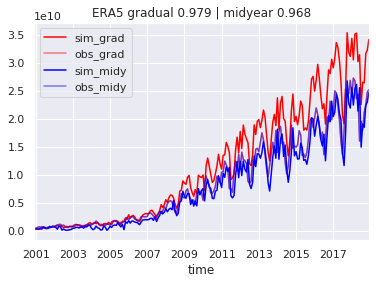

In [289]:
ax = plt.gca()
ds = pd.concat([comp_USAm.ERA5,comp_USAm.wp_obs,comp_USAEm.Ryberg,comp_USAEm.wp_obs],axis=1)
ds.columns = ['sim_grad','obs_grad','sim_midy','obs_midy']
ds = ds.dropna()
ds.plot(kind='line',y='sim_grad',color='red',ax=ax)
ds.plot(kind='line',y='obs_grad',color='red',ax=ax,alpha=0.5)
ds.plot(kind='line',y='sim_midy',color='blue',ax=ax)
ds.plot(kind='line',y='obs_midy',color='blue',ax=ax,alpha=0.5)
plt.title('ERA5 gradual '+str(round(np.corrcoef(ds.sim_grad,ds.obs_grad)[0,1],3)) +
          ' | midyear ' + str(round(np.corrcoef(ds.sim_midy,ds.obs_midy)[0,1],3)))


In [ ]:
plt.plot(comp_USAm.ERA5-comp_USAEm.Ryberg)

In [ ]:
plt.boxplot([(comp_USAm.ERA5-comp_USAEm.Ryberg),(comp_USAm.MERRA2-comp_USAMm.Ryberg)],labels=['ERA5','MERRA2'])
plt.title('gradual - midyear generation')

### Capacity factors

In [ ]:
ds = pd.concat([cf_USAm.MERRA2,cf_USAMm.Ryberg],axis=1)
ds.columns = ['gradual','midyear']
ds.plot()
plt.title('MERRA2 gradual vs midyear')

In [ ]:
ds = pd.concat([cf_USAm.ERA5,cf_USAEm.Ryberg],axis=1)
ds.columns = ['gradual','midyear']
ds.plot()
plt.title('ERA5 gradual vs midyear')

In [ ]:
ds = cf_USAm
ds.plot()
plt.title('MERRA2 '+str(round(np.corrcoef(ds.MERRA2,ds.wp_obs)[0,1],3)) +
          ' | ERA5 ' + str(round(np.corrcoef(ds.ERA5,ds.wp_obs)[0,1],3)))

In [ ]:
ds = pd.concat([cf_USAm.MERRA2,cf_USAm.wp_obs,cf_USAMm.Ryberg,cf_USAMm.wp_obs],axis=1)
ds.columns = ['sim_grad','obs_grad','sim_midy','obs_midy']
ds.plot()
plt.title('MERRA2 gradual '+str(round(np.corrcoef(ds.sim_grad,ds.obs_grad)[0,1],3)) +
          ' | midyear ' + str(round(np.corrcoef(ds.sim_midy,ds.obs_midy)[0,1],3)))

Text(0.5, 1.0, 'MERRA2 gradual 0.495 | midyear 0.418')

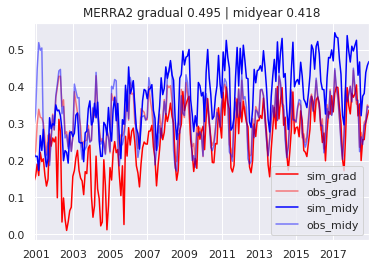

In [296]:
ax = plt.gca()
ds = pd.concat([cf_USAm.MERRA2,cf_USAm.wp_obs,cf_USAMm.Ryberg,cf_USAMm.wp_obs],axis=1)
ds.columns = ['sim_grad','obs_grad','sim_midy','obs_midy']
ds.plot(kind='line',y='sim_grad',color='red',ax=ax)
ds.plot(kind='line',y='obs_grad',color='red',ax=ax,alpha=0.5)
ds.plot(kind='line',y='sim_midy',color='blue',ax=ax)
ds.plot(kind='line',y='obs_midy',color='blue',ax=ax,alpha=0.5)
plt.title('MERRA2 gradual '+str(round(np.corrcoef(ds.sim_grad,ds.obs_grad)[0,1],3)) +
          ' | midyear ' + str(round(np.corrcoef(ds.sim_midy,ds.obs_midy)[0,1],3)))

In [ ]:
ds = pd.concat([cf_USAm.ERA5,cf_USAm.wp_obs,cf_USAEm.Ryberg,cf_USAEm.wp_obs],axis=1)
ds.columns = ['sim_grad','obs_grad','sim_midy','obs_midy']
ds.plot()
plt.title('ERA5 gradual '+str(round(np.corrcoef(ds.sim_grad,ds.obs_grad)[0,1],3)) +
          ' | midyear ' + str(round(np.corrcoef(ds.sim_midy,ds.obs_midy)[0,1],3)))

Text(0.5, 1.0, 'ERA5 gradual 0.544 | midyear 0.439')

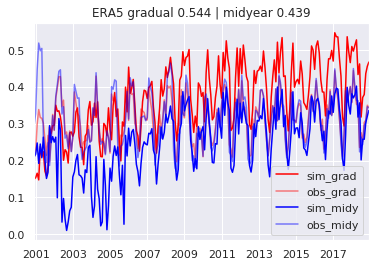

In [298]:
ax = plt.gca()
ds = pd.concat([cf_USAm.ERA5,cf_USAm.wp_obs,cf_USAEm.Ryberg,cf_USAEm.wp_obs],axis=1)
ds.columns = ['sim_grad','obs_grad','sim_midy','obs_midy']
ds.plot(kind='line',y='sim_grad',color='red',ax=ax)
ds.plot(kind='line',y='obs_grad',color='red',ax=ax,alpha=0.5)
ds.plot(kind='line',y='sim_midy',color='blue',ax=ax)
ds.plot(kind='line',y='obs_midy',color='blue',ax=ax,alpha=0.5)
plt.title('ERA5 gradual '+str(round(np.corrcoef(ds.sim_grad,ds.obs_grad)[0,1],3)) +
          ' | midyear ' + str(round(np.corrcoef(ds.sim_midy,ds.obs_midy)[0,1],3)))


In [ ]:
plt.scatter(cf_USAm.MERRA2,cf_USAMm.Ryberg)

In [ ]:
plt.scatter(wpM.wp,wpM_grad.wp,alpha=0.5)

In [302]:
np.where(wpM.wp==wpM_grad.wp)

(array([], dtype=int64),)

In [ ]:
# index for year ends
ind = pd.date_range('31/12/2001 23:00:00','31/12/2018 23:00:00',freq='y')
comp_yearendsE = pd.concat([wpE.loc[ind],wpE_grad.loc[ind]],axis=1)
comp_yearendsE.columns = ['midyear','gradual']
comp_yearendsE.plot()

In [ ]:
plt.plot(comp_yearendsE.midyear-comp_yearendsE.gradual)

In [ ]:
# index for year ends
ind = pd.date_range('31/12/2001 23:00:00','31/12/2018 23:00:00',freq='y')
comp_yearendsM = pd.concat([wpM.loc[ind],wpM_grad.loc[ind]],axis=1)
comp_yearendsM.columns = ['midyear','gradual']
comp_yearendsM.plot()

In [ ]:
plt.plot(comp_yearendsM.midyear-comp_yearendsM.gradual)

In [ ]:
plt.plot(cap_usa)
plt.plot(cap_usa_grad)

In [198]:
caps_ag = pd.Series(cap).groupby(comyear).sum()

In [199]:
dates = [pd.date_range(np.datetime64(str(year)+'-01-01 00:00:00'),np.datetime64(str(year)+'-12-31 23:00:00'),freq='H') for year in range(2000,2019)]

In [200]:
fact = np.concatenate([np.arange(1,x+1)/x for x in [len(y) for y in dates]])

In [201]:
y = range(2000,2019)
years = [[y[i]]*len(dates[i]) for i in range(len(y))]

In [202]:
capsy = xr.DataArray(np.ones(len(fact)*len(dates)).reshape(len(dates),len(fact)),
                     dims = ['year','time'],
                     coords = {'year':range(2000,2019),
                               'time':pd.date_range(np.datetime64('2000-01-01'),
                                                    np.datetime64('2018-12-31 23:00:00'),freq='H')})

In [203]:
capsy.loc[{'year':xr.DataArray(np.concatenate(years),dims='cy'),
           'time':xr.DataArray(np.concatenate(dates),dims='cy')}] = fact

In [204]:
comdates = xr.DataArray([np.datetime64(str(i)+'-01-01 00:00:00') for i in y],
                        dims='year',
                        coords={'year':y})

In [205]:
capsy_com = capsy.where(capsy.time>=comdates,0)

In [ ]:
capsy_com.plot()

In [382]:
caps_ag2000_18 = caps_ag[(caps_ag.index>=2000)&(caps_ag.index <=2018)]
caps_ag2000_18[2000] = caps_ag2000_18[2000]+caps_ag[caps_ag.index<2000].sum()
caps_fin = capsy_com * xr.DataArray(caps_ag2000_18,dims='year')

In [ ]:
caps_fin.plot()

In [384]:
caps_new = caps_fin.sum('year').to_dataframe(name='cap')

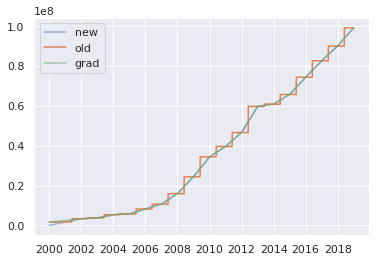

In [391]:
plt.plot(caps_new.tz_localize('UTC').tz_convert('US/Central'),label='new',alpha=0.5)
plt.plot(cap_usa,label='old')
plt.plot(cap_usa_grad,label='grad',alpha=0.5)
plt.legend()